<a href="https://colab.research.google.com/github/mukesh527/Traffic_Sign_Classification_with_CNN/blob/main/TS_classificationv2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
from tensorflow.keras.utils import to_categorical

os.chdir('/content/gdrive/MyDrive/CNN/Traffic sign classification/FullIJCNN2013/')
os.getcwd()


'/content/gdrive/MyDrive/CNN/Traffic sign classification/FullIJCNN2013'

#Code to crop the image


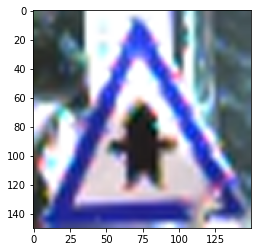

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img=cv2.imread('00000.ppm')
plt.imshow(img)
cropped=img[411:446,774:816]
cropped.shape
cropped = cv2.resize(cropped, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
plt.imshow(cropped)


#Function to crop image


In [4]:
def crop(img,left,top,right,bottom):
  img=cv2.imread(img)
  crop=img[top:bottom,left:right]
  crop=crop/255.0
  crop=cv2.resize(crop,dsize=(150,150),interpolation=cv2.INTER_CUBIC)
  return crop

In [5]:
import pandas as pd
gt=pd.read_csv('/content/gdrive/MyDrive/CNN/Traffic sign classification/FullIJCNN2013/gt.csv',delimiter=';',header=None)
gt.columns=['image_name','leftcol','toprow','rightcol','bottomrow','class']
gt
images=[]
for row in range(0,gt.shape[0]):
  images.append(crop(gt.iloc[row,0],gt.iloc[row,1],gt.iloc[row,2],gt.iloc[row,3],gt.iloc[row,4]))


In [6]:
datax=np.array(images)
datay=np.array(gt['class'])
datay=to_categorical(datay)
datax[0]

array([[[0.33810446, 0.4458296 , 0.37825215],
        [0.33998332, 0.44528472, 0.38072953],
        [0.3468666 , 0.44335556, 0.38968821],
        ...,
        [0.29341046, 0.35754789, 0.38447931],
        [0.29967852, 0.36196125, 0.39142797],
        [0.30133998, 0.3631714 , 0.39335017]],

       [[0.33588028, 0.44334899, 0.37534435],
        [0.33777114, 0.44283411, 0.37789976],
        [0.34469504, 0.44100764, 0.38713038],
        ...,
        [0.29252984, 0.35665197, 0.38329702],
        [0.29864554, 0.36093441, 0.39005271],
        [0.30026499, 0.36210855, 0.39192089]],

       [[0.32442776, 0.43060346, 0.3602011 ],
        [0.32638123, 0.43024154, 0.3631742 ],
        [0.33351721, 0.42893714, 0.37386119],
        ...,
        [0.28780547, 0.35184952, 0.3769786 ],
        [0.293114  , 0.35543443, 0.38270447],
        [0.29451176, 0.35641767, 0.38428529]],

       ...,

       [[0.24238352, 0.1977761 , 0.18461589],
        [0.25059316, 0.20225407, 0.19599534],
        [0.28277958, 0

#Data Augmentatoin Techniques

In [21]:
gt.shape

(1213, 6)

#Augumentation with rotation


In [7]:
lis_datax=list(datax)
lis_datay=list(datay)
def random_rotation(img,cat):
  samples=expand_dims(img,0)
  datagen = ImageDataGenerator(rotation_range=90)
  it = datagen.flow(samples, batch_size=1)
  
  for i in range(3):
    	
      # generate batch of images
      batch = it.next()
      # convert to unsigned integers for viewing
      lis_datax.append(batch[0].astype('float16'))
      lis_datay.append(cat)
  return lis_datax,lis_datay
    
 


#Augumentation with horizontal and vertical flips


In [8]:
def random_flips(img,cat):
  samples=expand_dims(img,0)
  datagen = ImageDataGenerator(horizontal_flip=True)
  it = datagen.flow(samples, batch_size=1)
  
  for i in range(3):
    	
      # generate batch of images
      batch = it.next()
      # convert to unsigned integers for viewing
      lis_datax.append(batch[0].astype('float16'))
      lis_datay.append(cat)
  return lis_datax,lis_datay
    

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
for row in range(0,datax.shape[0]):
  new_datax,new_datay=random_rotation(datax[row],datay[row])
  new_datax,new_datay=random_flips(datax[row],datay[row])



In [10]:
new_datax=np.array(new_datax)
new_datay=np.array(new_datay)
new_datax.shape

(8491, 150, 150, 3)

#Model Building


In [11]:
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, MaxPool2D,Dense,BatchNormalization
from keras.optimizers import SGD,Adam

In [12]:
def define_model():
  model=Sequential()
  model.add(Conv2D(32,(3,3),activation='relu',padding='same',kernel_initializer='he_uniform',input_shape=(150,150,3)))
  model.add(MaxPool2D(2,2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_uniform'))
  model.add(MaxPool2D(2,2))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_uniform'))
  model.add(MaxPool2D(2,2))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(43,activation='softmax'))
  opt=SGD(learning_rate=0.001,momentum=0.9)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  model.save('final_model.h5')
  return model


In [13]:
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()

In [14]:
def run_test_harness():
  #load dataset
  trainX,testX,trainY,testY=train_test_split(new_datax,new_datay,test_size=0.3,random_state=42)
  
  model=define_model()
  history=model.fit(trainX,trainY,epochs=10,batch_size=64,validation_data=(testX,testY),verbose=1)
  _,acc=model.evaluate(testX,testY,verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)
  return acc*100

In [ ]:
run_test_harness()

In [43]:
 trainX,trainY,testX,testY=train_test_split(datax,datay,test_size=0.3,random_state=42)

In [51]:
trainY.shape

(364, 150, 150, 3)